# Superstore

## Setup

In [65]:
# Modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
import shap

# ML Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
# ML Metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

In [66]:
df = pd.read_excel('/content/drive/MyDrive/Data Science/Github/tableau/Superstore-ed.xlsx')

## Objective: Predict Order Profitability (Classification)

**Objective:** We aim to predict whether an order will be profitable (i.e., Profit > 0) using information available prior to delivery. This can support the sales department in making better decisions, prioritizing high-potential orders, and identifying products or customers at risk of generating losses.

**Business Use Case:** Prioritize incoming orders and flag those with a higher risk of financial loss.

**Type:** Binary classification

Class 1: Profitable (Profit > 0)

Class 0: Not Profitable (Profit ≤ 0)

Target Variable:
Profitable = 1 if Profit > 0 else 0

**Models Considered:**

Logistic Regression

Random Forest

XGBoost

## Visualize the Dataset (EDA)

In [67]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,2020-11-08,2020-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,2020-06-12,2020-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,2019-10-11,2019-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [68]:
df.shape

(9994, 21)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

In [70]:
# Set the index variable
# df.set_index('Row ID', inplace=True)

## Missing Values

### Find missing values

In [71]:
# Display missing values
df.isnull().sum()

,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country/Region,0
City,0


### Visualize missing values


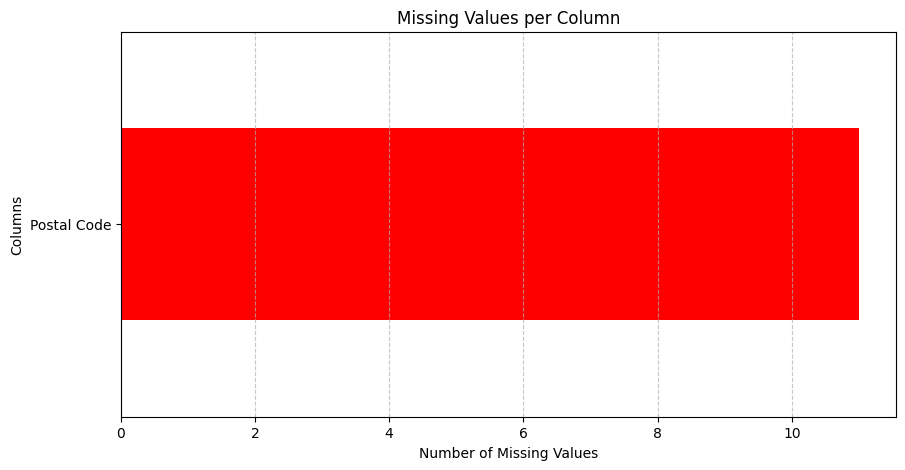

In [72]:
missing = df.isnull().sum()
missing = missing[missing > 0]

if not missing.empty:
    plt.figure(figsize=(10, 5))
    missing.sort_values(ascending=True).plot(kind='barh', color='red')
    plt.title('Missing Values per Column')
    plt.xlabel('Number of Missing Values')
    plt.ylabel('Columns')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("No missing values found in the dataset.")

We observe that only the Postal Code column contains missing values, accounting for approximately 0.11% of the entire dataset. While this is a very small proportion and these rows could be safely removed without significant impact, we will first explore whether it's possible to impute the missing values in a meaningful way.

### Impute missing values in Postal Code

In [73]:
# Check where are those values and if they have City, State and Region
df[df['Postal Code'].isnull()][['Order ID', 'Customer Name', 'City', 'State', 'Region', 'Postal Code']]

,Order ID,Customer Name,City,State,Region,Postal Code
2234,CA-2021-104066,Quincy Jones,Burlington,Vermont,East,NaN
5274,CA-2019-162887,Stewart Visinsky,Burlington,Vermont,East,NaN
8798,US-2020-150140,Valerie Mitchum,Burlington,Vermont,East,NaN
9146,US-2020-165505,Claudia Bergmann,Burlington,Vermont,East,NaN
9147,US-2020-165505,Claudia Bergmann,Burlington,Vermont,East,NaN
9148,US-2020-165505,Claudia Bergmann,Burlington,Vermont,East,NaN
9386,US-2021-127292,Raymond Messe,Burlington,Vermont,East,NaN
9387,US-2021-127292,Raymond Messe,Burlington,Vermont,East,NaN
9388,US-2021-127292,Raymond Messe,Burlington,Vermont,East,NaN
9389,US-2021-127292,Raymond Messe,Burlington,Vermont,East,NaN


In [74]:
# Check if there is another field with that postal code
df[(df['City'] == 'Burlington') | (df['State'] == 'Vermont') & (df['Postal Code'].notnull())]

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
683,684,US-2021-168116,2021-11-04,2021-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,27217.0,South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
684,685,US-2021-168116,2021-11-04,2021-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,27217.0,South,OFF-AP-10002457,Office Supplies,Appliances,Eureka The Boss Plus 12-Amp Hard Box Upright V...,167.440,2,0.2,14.6510
1008,1009,US-2021-106705,2021-12-26,2022-01-01,Standard Class,PO-18850,Patrick O'Brill,Consumer,United States,Burlington,...,52601.0,Central,OFF-PA-10001509,Office Supplies,Paper,"Recycled Desk Saver Line ""While You Were Out"" ...",44.750,5,0.0,20.5850
1038,1039,CA-2021-121818,2021-11-20,2021-11-21,First Class,JH-15430,Jennifer Halladay,Consumer,United States,Burlington,...,27217.0,South,OFF-AR-10000203,Office Supplies,Art,Newell 336,23.968,7,0.2,2.6964
1039,1040,CA-2021-121818,2021-11-20,2021-11-21,First Class,JH-15430,Jennifer Halladay,Consumer,United States,Burlington,...,27217.0,South,OFF-AR-10004790,Office Supplies,Art,Staples in misc. colors,28.728,3,0.2,1.7955
1393,1394,CA-2021-124828,2021-07-03,2021-07-04,First Class,YS-21880,Yana Sorensen,Corporate,United States,Burlington,...,27217.0,South,OFF-AR-10003514,Office Supplies,Art,4009 Highlighters by Sanford,9.552,3,0.2,1.5522
2234,2235,CA-2021-104066,2021-12-05,2021-12-10,Standard Class,QJ-19255,Quincy Jones,Corporate,United States,Burlington,...,NaN,East,TEC-AC-10001013,Technology,Accessories,Logitech ClearChat Comfort/USB Headset H390,205.030,7,0.0,67.6599
2928,2929,US-2021-120390,2021-10-19,2021-10-26,Standard Class,TH-21550,Tracy Hopkins,Home Office,United States,Burlington,...,27217.0,South,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1633.188,4,0.7,-1306.5504
5065,5066,CA-2021-142090,2021-11-30,2021-12-07,Standard Class,SC-20380,Shahid Collister,Consumer,United States,Burlington,...,27217.0,South,TEC-AC-10002001,Technology,Accessories,Logitech Wireless Gaming Headset G930,383.976,3,0.2,81.5949
5066,5067,CA-2021-142090,2021-11-30,2021-12-07,Standard Class,SC-20380,Shahid Collister,Consumer,United States,Burlington,...,27217.0,South,FUR-TA-10001889,Furniture,Tables,Bush Advantage Collection Racetrack Conference...,1781.682,7,0.4,-653.2834


In [75]:
# Inspect non-null Postal Code entries for City == 'Burlington'
burlington_postals = df[(df['City'] == 'Burlington') & (df['Postal Code'].notnull())]
burlington_postals

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
683,684,US-2021-168116,2021-11-04,2021-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,27217.0,South,TEC-MA-10004125,Technology,Machines,Cubify CubeX 3D Printer Triple Head Print,7999.980,4,0.5,-3839.9904
684,685,US-2021-168116,2021-11-04,2021-11-04,Same Day,GT-14635,Grant Thornton,Corporate,United States,Burlington,...,27217.0,South,OFF-AP-10002457,Office Supplies,Appliances,Eureka The Boss Plus 12-Amp Hard Box Upright V...,167.440,2,0.2,14.6510
1008,1009,US-2021-106705,2021-12-26,2022-01-01,Standard Class,PO-18850,Patrick O'Brill,Consumer,United States,Burlington,...,52601.0,Central,OFF-PA-10001509,Office Supplies,Paper,"Recycled Desk Saver Line ""While You Were Out"" ...",44.750,5,0.0,20.5850
1038,1039,CA-2021-121818,2021-11-20,2021-11-21,First Class,JH-15430,Jennifer Halladay,Consumer,United States,Burlington,...,27217.0,South,OFF-AR-10000203,Office Supplies,Art,Newell 336,23.968,7,0.2,2.6964
1039,1040,CA-2021-121818,2021-11-20,2021-11-21,First Class,JH-15430,Jennifer Halladay,Consumer,United States,Burlington,...,27217.0,South,OFF-AR-10004790,Office Supplies,Art,Staples in misc. colors,28.728,3,0.2,1.7955
1393,1394,CA-2021-124828,2021-07-03,2021-07-04,First Class,YS-21880,Yana Sorensen,Corporate,United States,Burlington,...,27217.0,South,OFF-AR-10003514,Office Supplies,Art,4009 Highlighters by Sanford,9.552,3,0.2,1.5522
2928,2929,US-2021-120390,2021-10-19,2021-10-26,Standard Class,TH-21550,Tracy Hopkins,Home Office,United States,Burlington,...,27217.0,South,OFF-BI-10004995,Office Supplies,Binders,GBC DocuBind P400 Electric Binding System,1633.188,4,0.7,-1306.5504
5065,5066,CA-2021-142090,2021-11-30,2021-12-07,Standard Class,SC-20380,Shahid Collister,Consumer,United States,Burlington,...,27217.0,South,TEC-AC-10002001,Technology,Accessories,Logitech Wireless Gaming Headset G930,383.976,3,0.2,81.5949
5066,5067,CA-2021-142090,2021-11-30,2021-12-07,Standard Class,SC-20380,Shahid Collister,Consumer,United States,Burlington,...,27217.0,South,FUR-TA-10001889,Furniture,Tables,Bush Advantage Collection Racetrack Conference...,1781.682,7,0.4,-653.2834
8317,8318,CA-2021-130904,2021-04-11,2021-04-16,Standard Class,HM-14980,Henry MacAllister,Consumer,United States,Burlington,...,27217.0,South,OFF-AR-10000422,Office Supplies,Art,Pencil and Crayon Sharpener,1.752,1,0.2,0.1533


In [76]:
# Examine the unique values
burlington_postals['Postal Code'].unique()

array([27217., 52601.])

In [77]:
# Find the mode
burlington_mode = burlington_postals['Postal Code'].mode()[0]
print("Moda del código postal en Burlington:", burlington_mode)

Moda del código postal en Burlington: 27217.0


In [78]:
# Impute the values with the mode of Burlington Postal Code
df.loc[(df['City'] == 'Burlington') & (df['State'] == 'Vermont') & (df['Postal Code'].isnull()), 'Postal Code'] = burlington_mode

In [79]:
# Display if there are missing values in postal code
df['Postal Code'].isnull().sum()

np.int64(0)

## Outliers

## Data cleaning and Feature Engineering

In [94]:
# Cleaning date columns
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Ship Date'] = pd.to_datetime(df['Ship Date'])

# Create the target variable "Rentable"
df['Rentable'] = (df['Profit'] > 0).astype(int)

# Feature Engineering
df['Shipping Time'] = (df['Ship Date'] - df['Order Date']).dt.days
df['Order Year'] = df['Order Date'].dt.year
df['Order Month'] = df['Order Date'].dt.month

# Show a preview with the new columns
df[['Sales', 'Profit', 'Rentable', 'Shipping Time', 'Order Year', 'Order Month']].head()

,Sales,Profit,Rentable,Shipping Time,Order Year,Order Month
0,261.9600,41.9136,1,3,2020,11
1,731.9400,219.5820,1,3,2020,11
2,14.6200,6.8714,1,4,2020,6
3,957.5775,-383.0310,0,7,2019,10
4,22.3680,2.5164,1,7,2019,10


## Machine Learning

### Machine Learning - Preprocessing

In [81]:
# Copy the original Dataframe
df_encoded = df.copy()

# Identify the columns to encode
categorical_columns = df_encoded.select_dtypes(include='object').columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Eliminate the columns are not needed for the model
columns_to_drop = ['Row ID', 'Order ID', 'Customer ID', 'Product ID', 'Product Name', 'Customer Name', 'Order Date', 'Ship Date', 'Profit']
df_encoded = df_encoded.drop(columns=columns_to_drop)

# Separate X e y
X = df_encoded.drop(columns=['Rentable'])
y = df_encoded['Rentable']

### Machine Learning - Train/Test

In [82]:
# Divide Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Retrain models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'KNN': KNeighborsClassifier()
}

trained_models = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    trained_models[name] = model

### SHAP(Shapley Additive exPlanations) for XGBoost model

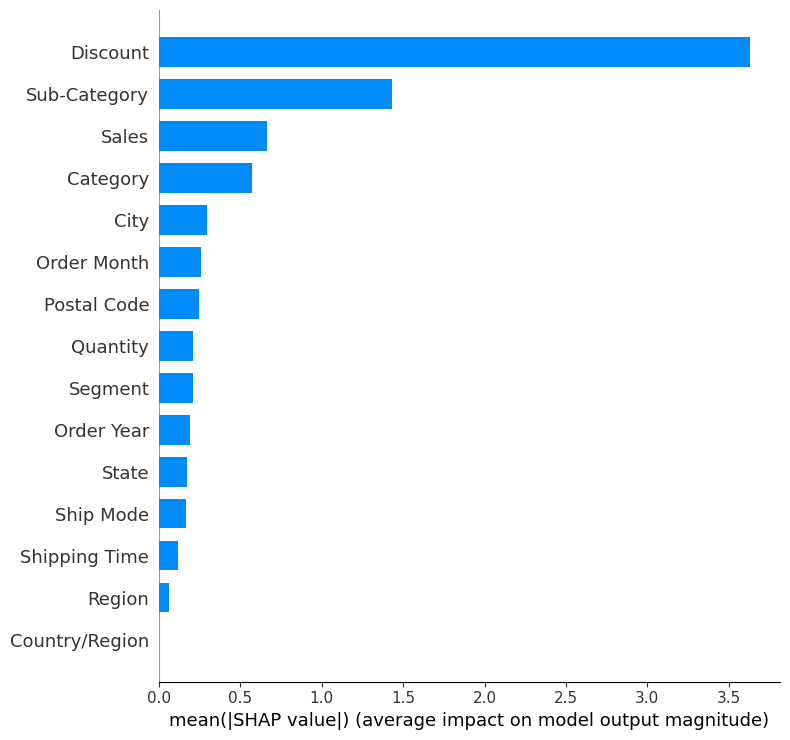

In [83]:
# SHAP(Shapley Additive exPlanations) for XGBoost model
import shap

# Create SHAP explainer for XGBoost
xgb_model = trained_models['XGBoost']
explainer = shap.Explainer(xgb_model)

# Calculate SHAP values for test data
shap_values = explainer(X_test)

# Summary plot (bar): average impact of features
shap.summary_plot(shap_values, X_test, plot_type='bar')

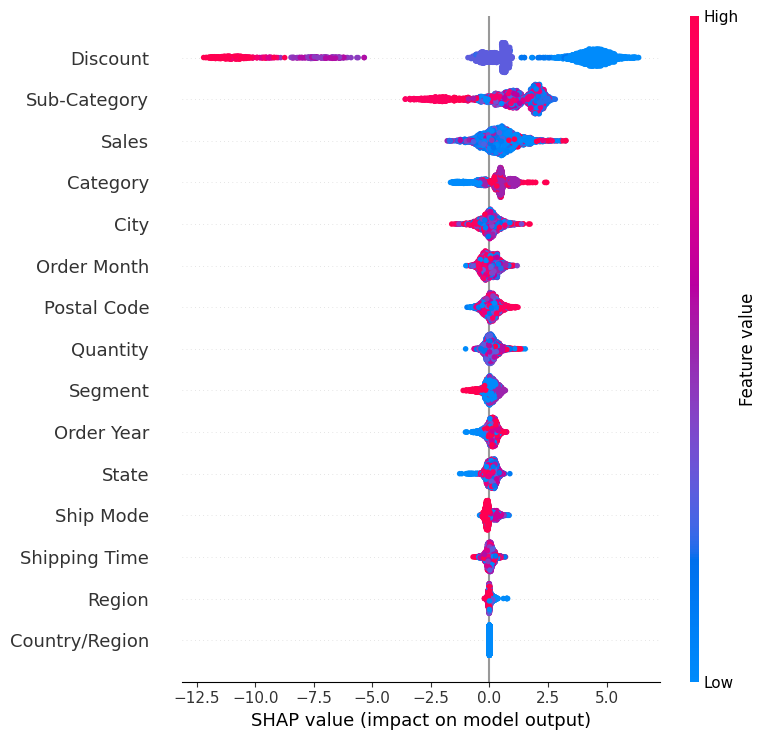

In [84]:
# Detailed summary plot: how features impact predictions
shap.summary_plot(shap_values, X_test)

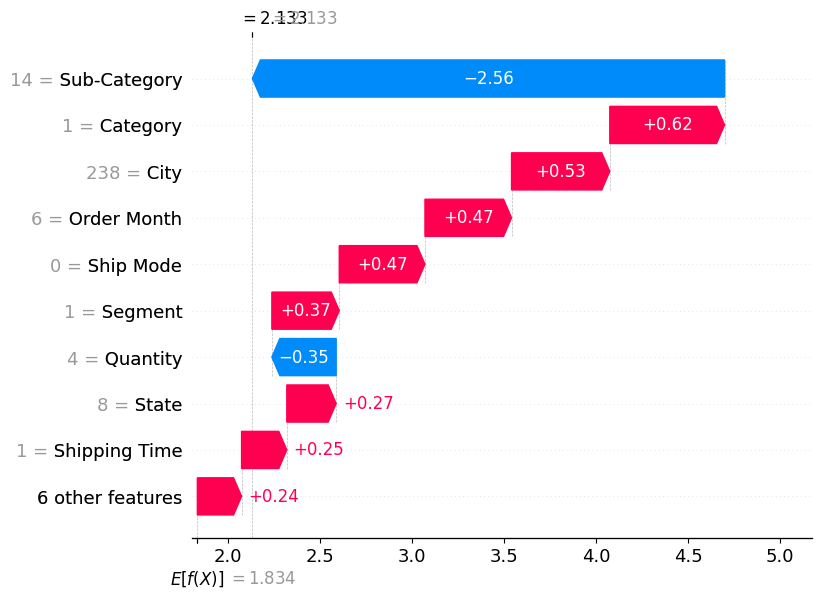

In [85]:
# Waterfall plot for a single prediction (optional, use index 0 or any)
shap.plots.waterfall(shap_values[0])

### Evaluate the models


📊 Model: Logistic Regression
{'0': {'f1-score': 0.4583333333333333,
       'precision': 0.6951672862453532,
       'recall': 0.34186471663619744,
       'support': 547.0},
 '1': {'f1-score': 0.9147047472018526,
       'precision': 0.8681318681318682,
       'recall': 0.966557911908646,
       'support': 2452.0},
 'accuracy': 0.8526175391797266,
 'macro avg': {'f1-score': 0.6865190402675929,
               'precision': 0.7816495771886107,
               'recall': 0.6542113142724217,
               'support': 2999.0},
 'weighted avg': {'f1-score': 0.8314652795839533,
                  'precision': 0.8365841434596696,
                  'recall': 0.8526175391797266,
                  'support': 2999.0}}
ROC AUC: 0.790


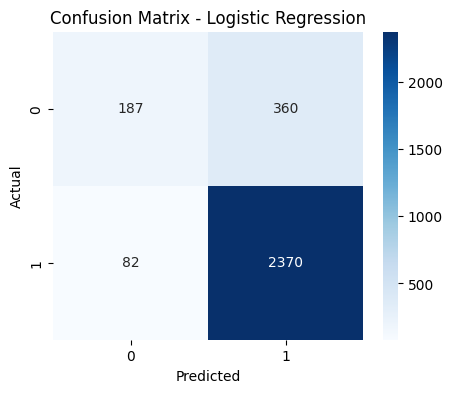


📊 Model: Random Forest
{'0': {'f1-score': 0.8215686274509804,
       'precision': 0.8858350951374208,
       'recall': 0.7659963436928702,
       'support': 547.0},
 '1': {'f1-score': 0.963439132181599,
       'precision': 0.9493269992082344,
       'recall': 0.9779771615008157,
       'support': 2452.0},
 'accuracy': 0.9393131043681227,
 'macro avg': {'f1-score': 0.8925038798162896,
               'precision': 0.9175810471728276,
               'recall': 0.871986752596843,
               'support': 2999.0},
 'weighted avg': {'f1-score': 0.9375627847032235,
                  'precision': 0.9377464485157586,
                  'recall': 0.9393131043681227,
                  'support': 2999.0}}
ROC AUC: 0.975


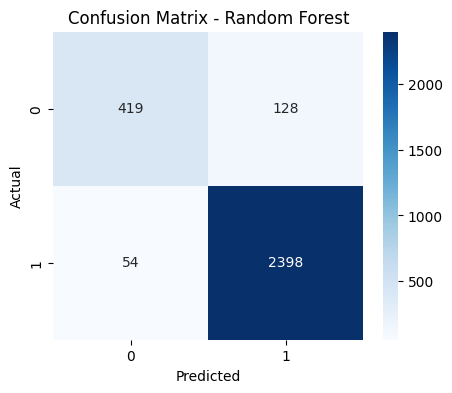


📊 Model: XGBoost
{'0': {'f1-score': 0.838468720821662,
       'precision': 0.8568702290076335,
       'recall': 0.8208409506398537,
       'support': 547.0},
 '1': {'f1-score': 0.9648873553886747,
       'precision': 0.9604040404040404,
       'recall': 0.9694127243066885,
       'support': 2452.0},
 'accuracy': 0.9423141047015672,
 'macro avg': {'f1-score': 0.9016780381051683,
               'precision': 0.908637134705837,
               'recall': 0.895126837473271,
               'support': 2999.0},
 'weighted avg': {'f1-score': 0.941829338346942,
                  'precision': 0.9415200808062295,
                  'recall': 0.9423141047015672,
                  'support': 2999.0}}
ROC AUC: 0.979


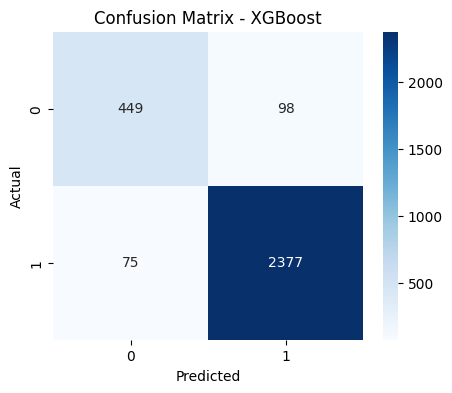


📊 Model: KNN
{'0': {'f1-score': 0.4665314401622718,
       'precision': 0.5239179954441914,
       'recall': 0.42047531992687387,
       'support': 547.0},
 '1': {'f1-score': 0.8950518754988028,
       'precision': 0.876171875,
       'recall': 0.914763458401305,
       'support': 2452.0},
 'accuracy': 0.8246082027342447,
 'macro avg': {'f1-score': 0.6807916578305373,
               'precision': 0.7000449352220957,
               'recall': 0.6676193891640895,
               'support': 2999.0},
 'weighted avg': {'f1-score': 0.8168922629182486,
                  'precision': 0.8119228346141956,
                  'recall': 0.8246082027342447,
                  'support': 2999.0}}
ROC AUC: 0.811


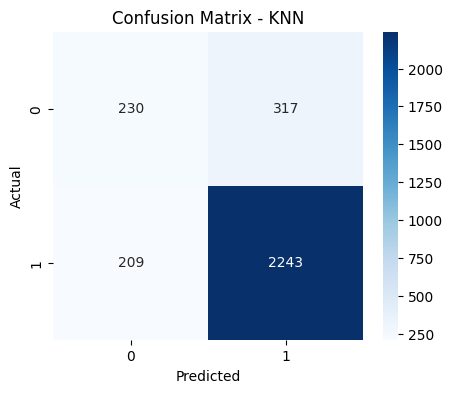

In [86]:
# Evaluate models
evaluation_results = {}
for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    evaluation_results[name] = {
        'classification_report': report,
        'roc_auc': auc,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Show Results
for name, result in evaluation_results.items():
    print(f"\n📊 Model: {name}")
    pprint.pprint(result['classification_report'])
    print(f"ROC AUC: {result['roc_auc']:.3f}")
    plt.figure(figsize=(5, 4))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Extra: Feature Importance(Random Forest y XGBoost)

In [87]:
# 📌 Feature Importance - Random Forest y XGBoost
importances_rf = trained_models['Random Forest'].feature_importances_
importances_xgb = trained_models['XGBoost'].feature_importances_
features = X.columns

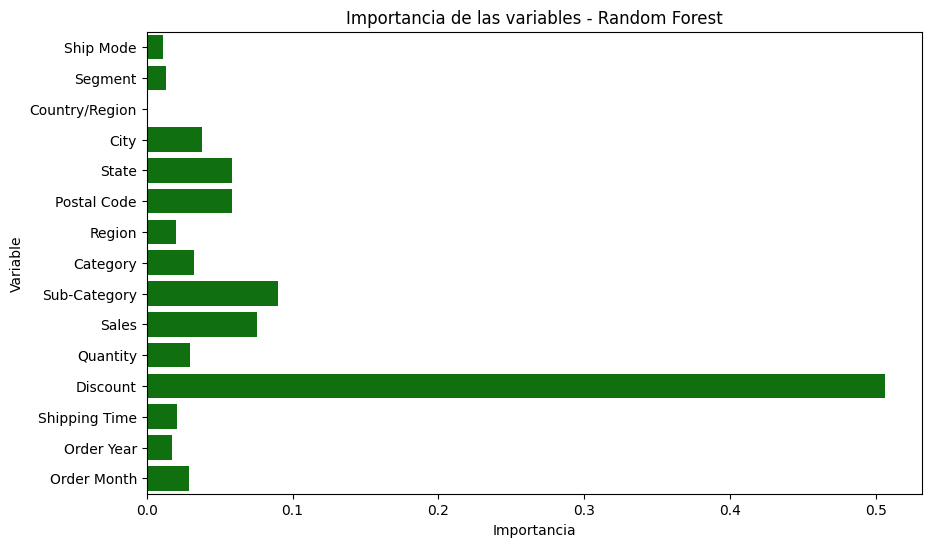

In [88]:
# Visualización Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_rf, y=features, color='green')
plt.title("Importancia de las variables - Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

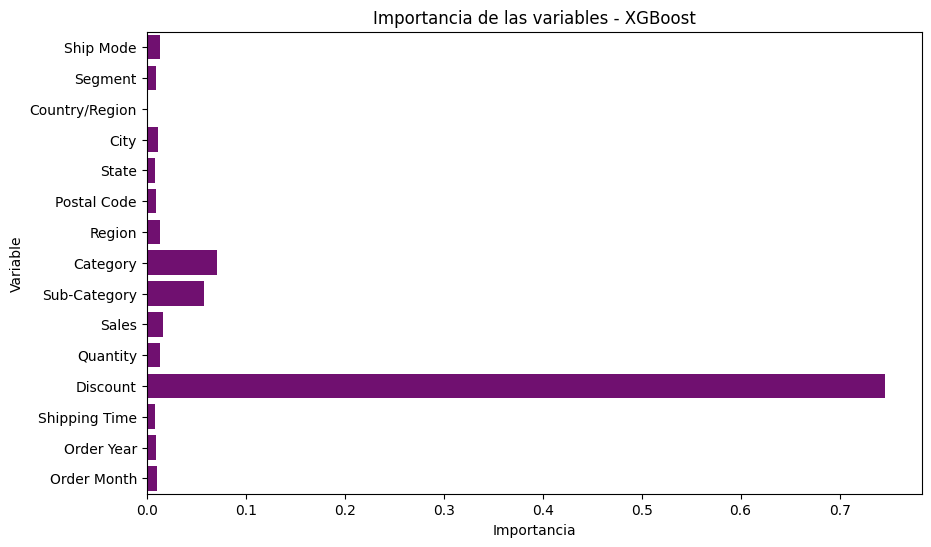

In [89]:
# Visualización XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=importances_xgb, y=features, color='purple')
plt.title("Importancia de las variables - XGBoost")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.show()

## Curva ROC for all the Machile Learning models

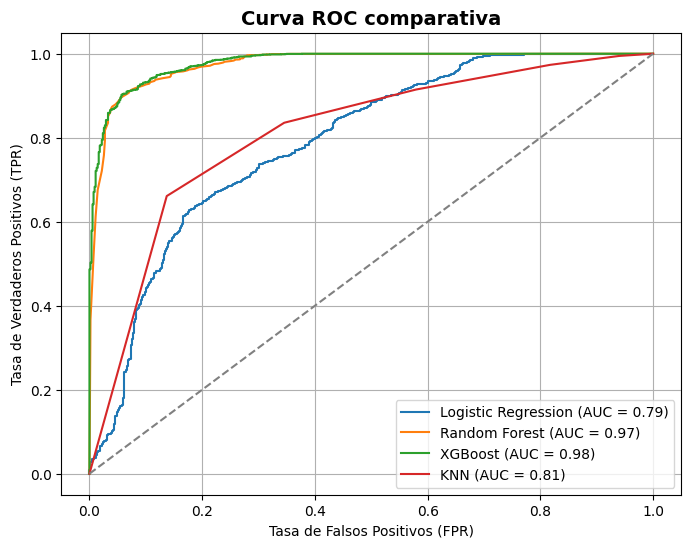

In [90]:
# 📈 Curva ROC de todos los modelos
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, model in trained_models.items():
    # Si el modelo tiene predict_proba (KNN, RandomForest, etc.)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Línea base (modelo aleatorio)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('Curva ROC comparativa', fontsize=14, fontweight='bold')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.grid()
plt.show()

## Metrics Summary Table

In [91]:
# Summary Results
summary_results = []

for name, model in trained_models.items():
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    summary_results.append({
        'Model': name,
        'Accuracy': round(accuracy, 3),
        'F1 Score': round(f1, 3),
        'ROC AUC': round(roc_auc, 3)
    })

summary_df = pd.DataFrame(summary_results).sort_values(by='ROC AUC', ascending=False)
display(summary_df)

,Model,Accuracy,F1 Score,ROC AUC
2,XGBoost,0.942,0.965,0.979
1,Random Forest,0.939,0.963,0.975
3,KNN,0.825,0.895,0.811
0,Logistic Regression,0.853,0.915,0.790


## Metrics Comparison Chart

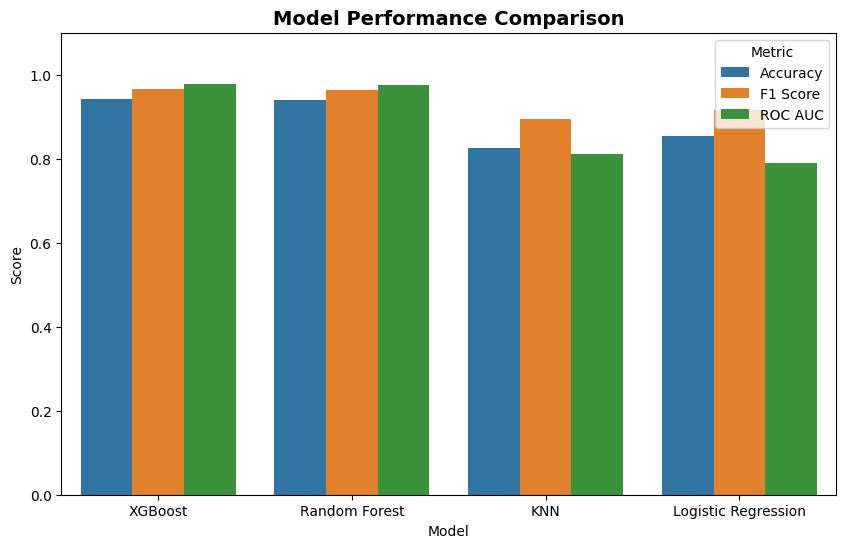

In [92]:
# Bar Plot for comparison of model metrics
summary_df_melted = summary_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10,6))
sns.barplot(data=summary_df_melted, x='Model', y='Score', hue='Metric')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.show()


## ✅ Final Conclusions

- This project aimed to predict order profitability using structured sales data and pre-delivery features.
- Several models were trained and compared, including Logistic Regression, KNN, Random Forest, and XGBoost.
- **XGBoost** consistently delivered the best performance in terms of **ROC AUC** and **F1-score**.
- Key predictors influencing profitability include `Discount`, `Sales`, `Category`, and `Shipping Time`, as confirmed by both model-based feature importance and SHAP analysis.
- The SHAP summary plots offered interpretable insights at both global and individual prediction levels, enhancing model transparency.

### 🚀 Next Steps
- Apply **hyperparameter tuning** (e.g., with GridSearchCV) to improve model performance.
- Incorporate **cost-sensitive learning** to account for potential business risk in misclassification.
- Explore **SHAP explanations** for critical or borderline decisions to support business actionability.
- Consider deployment of the XGBoost model as an internal decision-support tool for the sales or logistics team.

---

*End of notebook.*